In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, accuracy_score
from graspologic.embed import ClassicalMDS
from graspologic.utils import remap_labels
from ndd_utils import calculate_dissim

import sys  
from pathlib import Path  
file = Path('mami_clustering.ipynb').resolve() 
package_root_directory = file.parents[1] 

In [2]:
from ndd_utils import utils

# Clustering Dissimilarity Matrices
We will run the same clustering algorithms (Agglomerative, K-Means, and GMM) on the dissimilarity matrices obtained from the previous notebook. 

The [MAMI Dataset](https://zenodo.org/record/6382386) is opensource, and we use Version 2. The labels used for clustering were based on taxonomy orders using information obtained from 'data/info/info.csv'.

## Load Data

In [3]:
from pathlib import Path

graphs = np.zeros((225, 200, 200))
species_list = []

npy_files = Path('../mami_data/conn').glob('*')
for i, file in enumerate(npy_files):
    graphs[i] = np.load(file)
    filestr = str(file).split('/')[-1]
    filestr = filestr.split('.')[0]
    species_list.append(filestr)

print(len(species_list))
    

225


In [4]:
# construct labels based on taxonomy orders
info_df = pd.read_csv('../mami_data/info.csv')
filenames = info_df.pop("Filename").to_list()
orders = info_df.pop("Order").to_list()

order_mapper = {}
for i, filename in enumerate(filenames):
    if orders[i] == 'Artiodactyla':
        orders[i] = 'Cetartiodactyla'
    order_mapper[filename] = orders[i]

labels = list(map(order_mapper.get, species_list))

mapper = {}

for i, label in enumerate(set(labels)):
    mapper[label] = i
y = list(map(mapper.get, labels))

print(len(labels))
print(len(y))


225
225


In [5]:
def cluster_dissim(dissim_matrix: np.ndarray, labels: list, method="agg"):
    """
    Cluster dissimilarity matrix using Agglomerative, K-means, or GMM. 
    """
    if method == "agg":
        # Agglomerative clustering
        agg = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='average', \
            compute_distances=True).fit(dissim_matrix, y=labels)
        pred = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='average', \
            compute_distances=True).fit_predict(dissim_matrix, y=labels)

        # construct linkage matrix
        counts = np.zeros(agg.children_.shape[0])
        n_samples = len(agg.labels_)

        for i, merge in enumerate(agg.children_):
            temp_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    temp_count += 1 
                else:
                    temp_count += counts[child_idx - n_samples]
            counts[i] = temp_count

        linkage_matrix = np.column_stack([agg.children_, agg.distances_, counts]).astype(float)

        return linkage_matrix, pred
    
    elif method in ["gmm", "kmeans"]:
        # Classical MDS
        cmds = ClassicalMDS(n_components=2, dissimilarity="precomputed")
        cmds_embedding = cmds.fit_transform(dissim_matrix)

        # cluster using GMM or K-means
        if method == "gmm":
            clustering = GaussianMixture(n_components=4, n_init=25).fit_predict(cmds_embedding, y=labels)
        elif method == "kmeans":
            clustering = KMeans(n_clusters=4, n_init=25).fit_predict(cmds_embedding, y=labels)
        else:
            print("Not a valid kernel name.")

        return cmds_embedding, clustering
    
    else:
        print("Not a valid kernel name.")

In [6]:
def compare_preds(y_true, y_pred):
    """ Compare true and predicted labels and return list of 'Correct' or 'Incorrect'. """
    preds = []
    for i, pred in enumerate(y_pred):
        if pred == y_true[i]:
            preds.append("Correct")
        else:
            preds.append("Incorrect")
    
    return preds

In [7]:
def construct_df(embedding, labels, y_true, y_pred):
    """ Construct dataframe for plotting and remapped labels. Only for 'gmm' or 'kmeans'. """
    # x,y coordinates
    plot_df = pd.DataFrame(embedding, columns=["Dimension 1", "Dimension 2"])

    # predicted labels
    mapper_inv = {}
    for i, label in enumerate(set(labels)):
        mapper_inv[i] = label
    #mapper_inv = {0: 'B6', 1: 'BTBR', 2: 'CAST', 3: 'DBA2'}
    y_pred = remap_labels(y_true=y_true, y_pred=y_pred)
    pred_str = np.array([mapper_inv[l] for l in list(y_pred)])
    plot_df["Order"] = pred_str

    # determine if predictions are accurate for each sample
    preds = compare_preds(y_true, y_pred)
    plot_df["Predictions"] = preds

    return plot_df, y_pred

In [8]:
def plot_clustering(
    labels: list,
    algorithm: str = "agg",
    dissim_matrix: np.ndarray = None,
    linkage_matrix: np.ndarray = None,
    data: pd.DataFrame = None,
    **kwargs,
):
    sns.set_context("talk", font_scale=0.85)
    #palette = {"DBA2": "#e7298a", "B6": "#1b9e77", "BTBR": "#d95f02", "CAST": "#7570b3"}
    palette = dict(zip(set(labels), sns.color_palette("Paired", len(set(labels)))))
    colors = np.array([palette[l] for l in labels])

    if algorithm == "agg" and dissim_matrix is not None and linkage_matrix is not None:
        #df = pd.DataFrame(labels, columns = ['Labels'])
        
        #mice_labels = df.pop("Labels")
        #colors = mice_labels.map(palette).to_numpy()

        clustergrid = sns.clustermap(dissim_matrix, row_linkage=linkage_matrix, col_linkage=linkage_matrix, row_colors=colors, \
            col_colors=colors, cmap="RdBu_r", center=0, xticklabels=False, yticklabels=False, **kwargs)

        clustergrid.figure.set_facecolor('w')
        clustergrid.ax_cbar.set_title("Dissimilarity") # add color bar
        col_ax = clustergrid.ax_col_colors # add row and column colors
        #col_ax.set_yticks([0.5])
        #_ = col_ax.set_yticklabels(["Genotype"], va="center")
        patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in palette.items()] # add legend
        clustergrid.figure.legend(handles=patches, bbox_to_anchor = (1.23, 1), title='Order')

        return clustergrid
        
    elif algorithm in ["gmm", "kmeans"] and data is not None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='w')
        markers = {"Incorrect": "X", "Correct": "o"}
        sns.scatterplot(x="Dimension 1", y="Dimension 2", hue=labels, style="Predictions", data=data, \
            palette=palette, markers=markers, ax=ax, **kwargs)
        plt.legend(bbox_to_anchor = (1.05, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlabel('CMDS Dimension 1')
        ax.set_ylabel('CMDS Dimension 2')
        ax.tick_params(left=False, bottom=False)

        return ax
    
    else:
        print("If algorithm is 'agg', dissim_matrix and linkage_matrix must be given. If algorithm is 'gmm' or 'kmeans', \
            data must be given.")
    

## Agglomerative Clustering

Agglomerative clustering was used directly on the dissimilarity matrices, and the resulting linkage matrix and clusters were visualized with a heatmap below.

For each kernel, the accuracy score, the number of correct predictions divided by the total number of samples, and the adjusted rand index,  a similarity measure between two clusterings after being adjusted for chance, were reported. 

### Density

Accuracy: 0.29777777777777775
ARI: 0.04721333099593857


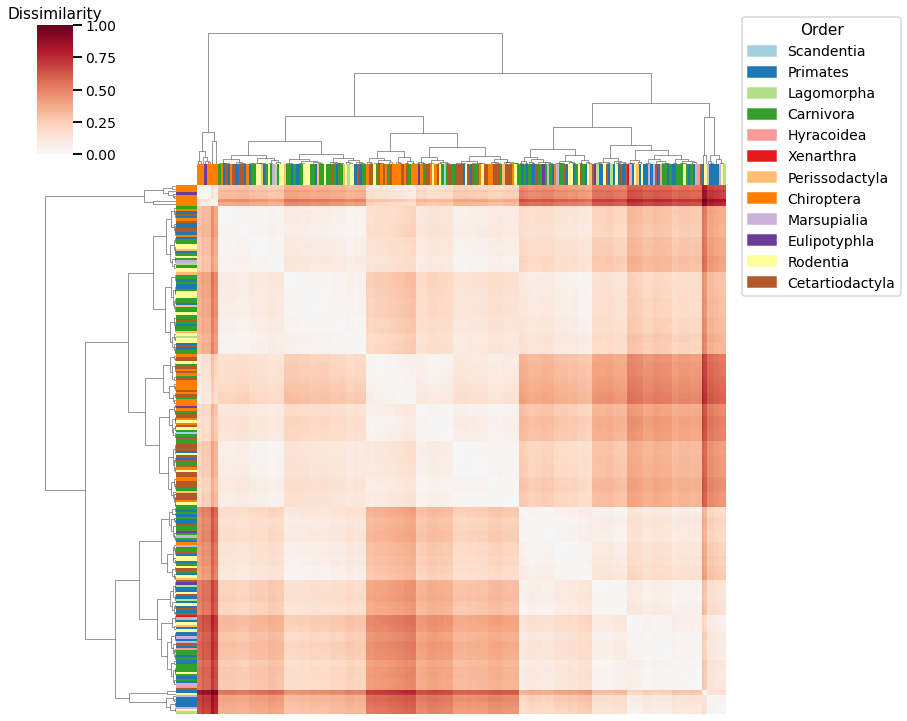

In [9]:
# calculate dissimilarity matrix
scaled_density_dissim = calculate_dissim(graphs, method="density", norm=None, normalize=True)

# cluster dissimilarity matrix
density_linkage_matrix, density_pred = cluster_dissim(scaled_density_dissim, y, method="agg")

# calculate accuracy and ARI
density_pred = remap_labels(y, density_pred)
density_agg_score = accuracy_score(y, density_pred)
density_agg_ari = adjusted_rand_score(y, density_pred)

print(f"Accuracy: {density_agg_score}")
print(f"ARI: {density_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_density_dissim, density_linkage_matrix)

### Average Edge Weight

Accuracy: 0.24888888888888888
ARI: 0.0016593207155820586


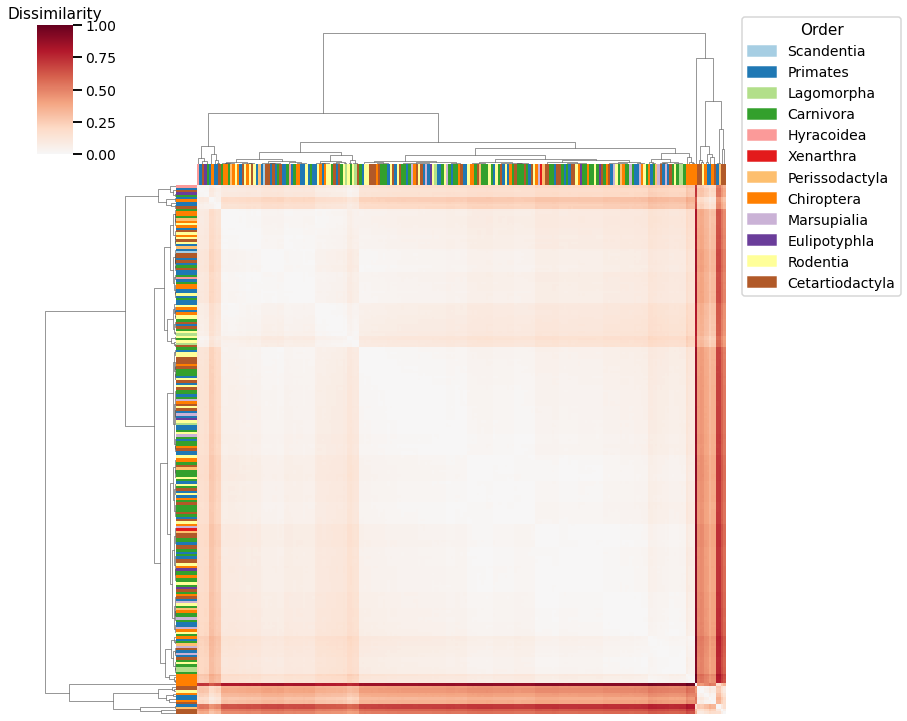

In [11]:
# calculate dissimilarity matrix
scaled_avgedgeweight_dissim = calculate_dissim(graphs, method="avgedgeweight", norm=None, normalize=True)

# cluster dissimilarity matrix
avgedgeweight_linkage_matrix, avgedgeweight_pred = cluster_dissim(scaled_avgedgeweight_dissim, y, method="agg")

# calculate accuracy and ARI
avgedgeweight_pred = remap_labels(y, avgedgeweight_pred)
avgedgeweight_agg_score = accuracy_score(y, avgedgeweight_pred)
avgedgeweight_agg_ari = adjusted_rand_score(y, avgedgeweight_pred)

print(f"Accuracy: {avgedgeweight_agg_score}")
print(f"ARI: {avgedgeweight_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_avgedgeweight_dissim, avgedgeweight_linkage_matrix)

### Average of Adjacency Matrix

Accuracy: 0.2577777777777778
ARI: 0.004045320847565635


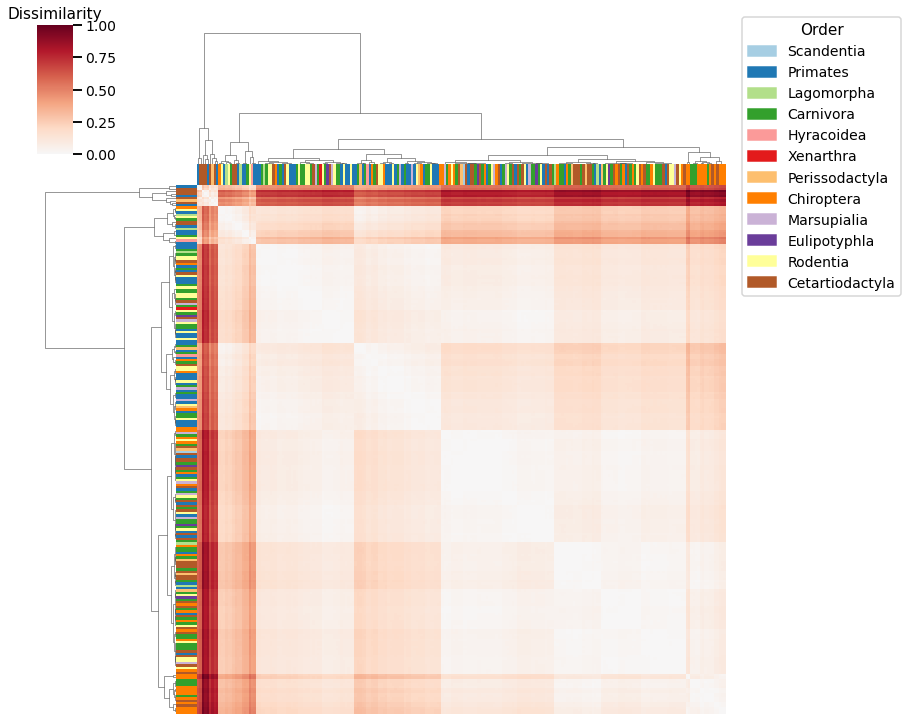

In [12]:
# calculate dissimilarity matrix
scaled_avgadjmat_dissim = calculate_dissim(graphs, method="avgadjmatrix", norm=None, normalize=True)

# cluster dissimilarity matrix
avgadjmat_linkage_matrix, avgadjmat_pred = cluster_dissim(scaled_avgadjmat_dissim, y, method="agg")

# calculate accuracy and ARI
avgadjmat_pred = remap_labels(y, avgadjmat_pred)
avgadjmat_agg_score = accuracy_score(y, avgadjmat_pred)
avgadjmat_agg_ari = adjusted_rand_score(y, avgadjmat_pred)

print(f"Accuracy: {avgadjmat_agg_score}")
print(f"ARI: {avgadjmat_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_avgadjmat_dissim, avgadjmat_linkage_matrix)

For unmatched datsets, we need to modify the kernels that use node degrees, node strength, and edge weights because they assume that the nodes are matches. Thus, we used the following modified function to calculate the dissimilarity matrices. 

In [13]:
from scipy.stats import ks_2samp
from scipy.special import kl_div
from hyppo.independence import Dcorr
from scipy.spatial import distance
from graspologic.utils import pass_to_ranks

def calculate_dissim_unmatched(graphs, method="density", normalize=True):
    """ Calculate the dissimilarity matrix using the input kernel. """
    if method == "degree":
        metric = np.zeros((graphs.shape[0], graphs.shape[1]))
        for i, graph in enumerate(graphs):
            for j, node in enumerate(graph):
                metric[i, j] = np.count_nonzero(node)
    
    elif method == "strength":
        metric = np.zeros((graphs.shape[0], graphs.shape[1]))
        for i, graph in enumerate(graphs):
            #graph = pass_to_ranks(graph)
            for j, node in enumerate(graph):
                metric[i, j] = np.sum(node)

    elif method == "edgeweight":
        metric = []
        for graph in graphs:
            metric.append(np.ravel(np.nonzero(graph)))
            
    else:
        print("Not a valid kernel name.")
    
    dissim_matrix = np.zeros((len(graphs), len(graphs)))
    for i, metric1 in enumerate(metric):
        for j, metric2 in enumerate(metric):
            diff, _ = ks_2samp(np.array(metric1), np.array(metric2), mode='asymp')
            #diff = kl_div(metric1, metric2)
            #diff = hellinger1(metric1, metric2)
            #diff = Dcorr().statistic(metric1.reshape(1,-1), metric2.reshape(1,-1))
            #diff = distance.correlation(metric1, metric2)
            dissim_matrix[i, j] = diff
            
    if normalize:
        dissim_matrix = dissim_matrix / np.max(dissim_matrix)
    
    return dissim_matrix

### Node Degrees

Accuracy: 0.3333333333333333
ARI: 0.059468976077266894


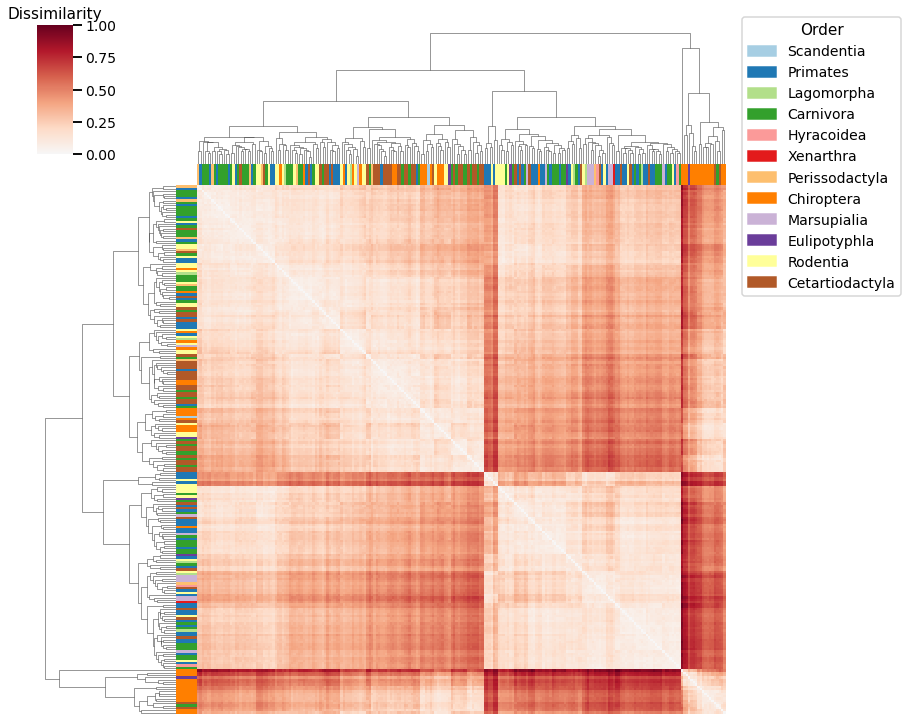

In [14]:
# calculate dissimilarity matrix
scaled_nodedeg_dissim = calculate_dissim_unmatched(graphs, method="degree", normalize=True)

# cluster dissimilarity matrix
nodedeg_linkage_matrix, nodedeg_pred = cluster_dissim(scaled_nodedeg_dissim, y, method="agg")

# calculate accuracy and ARI
nodedeg_pred = remap_labels(y, nodedeg_pred)
nodedeg_agg_score = accuracy_score(y, nodedeg_pred)
nodedeg_agg_ari = adjusted_rand_score(y, nodedeg_pred)

print(f"Accuracy: {nodedeg_agg_score}")
print(f"ARI: {nodedeg_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_nodedeg_dissim, nodedeg_linkage_matrix)

### Node Strength

Accuracy: 0.29333333333333333
ARI: 0.008976247615334715


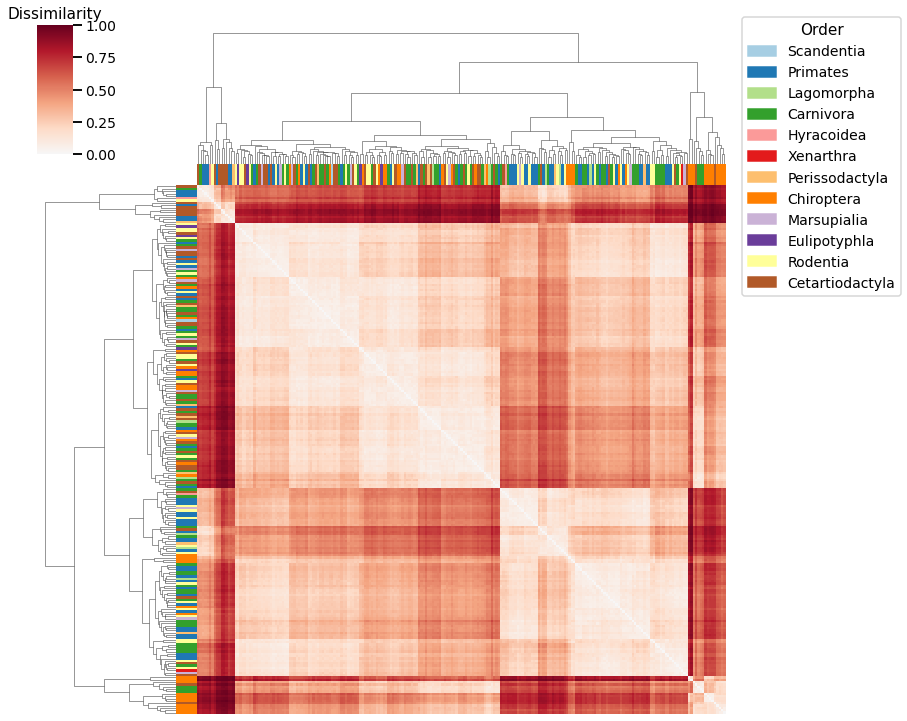

In [15]:
# calculate dissimilarity matrix
scaled_nodestr_dissim = calculate_dissim_unmatched(graphs, method="strength", normalize=True)

# cluster dissimilarity matrix
nodestr_linkage_matrix, nodestr_pred = cluster_dissim(scaled_nodestr_dissim, y, method="agg")

# calculate accuracy and ARI
nodestr_pred = remap_labels(y, nodestr_pred)
nodestr_agg_score = accuracy_score(y, nodestr_pred)
nodestr_agg_ari = adjusted_rand_score(y, nodestr_pred)

print(f"Accuracy: {nodestr_agg_score}")
print(f"ARI: {nodestr_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_nodestr_dissim, nodestr_linkage_matrix)

### Edge weights

Accuracy: 0.26666666666666666
ARI: 0.029741804269115532


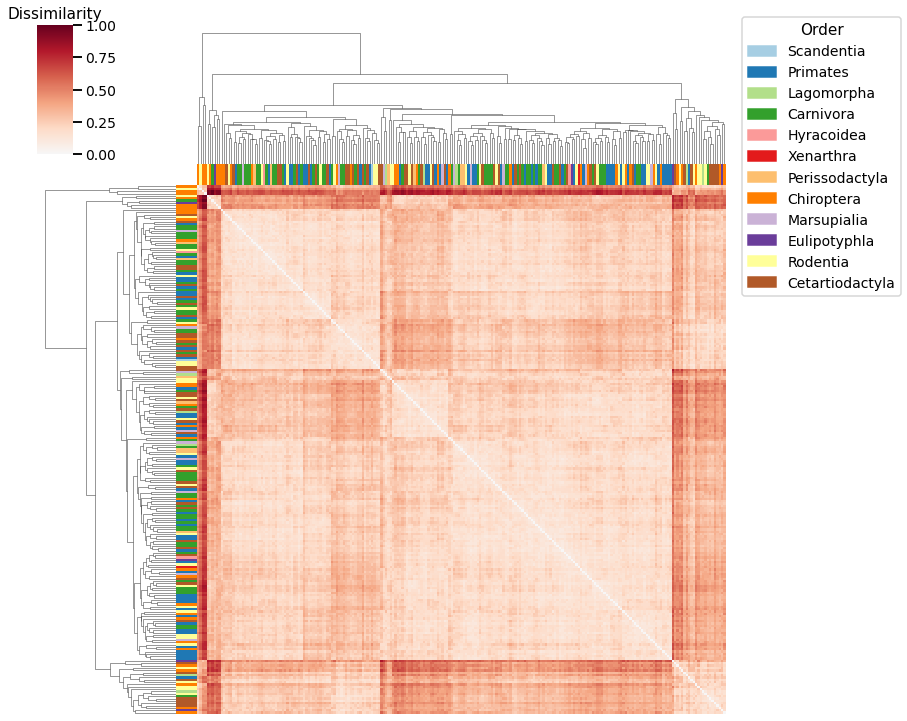

In [16]:
# calculate dissimilarity matrix
scaled_edgeweight_dissim = calculate_dissim_unmatched(graphs, method="edgeweight", normalize=True)

# cluster dissimilarity matrix
edgeweight_linkage_matrix, edgeweight_pred = cluster_dissim(scaled_edgeweight_dissim, y, method="agg")

# calculate accuracy and ARI
edgeweight_pred = remap_labels(y, edgeweight_pred)
edgeweight_agg_score = accuracy_score(y, edgeweight_pred)
edgeweight_agg_ari = adjusted_rand_score(y, edgeweight_pred)

print(f"Accuracy: {edgeweight_agg_score}")
print(f"ARI: {edgeweight_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_edgeweight_dissim, edgeweight_linkage_matrix)

### Omnibus Embedding (Change to Latent Distribution Test)

## GMM

We used classical multidimensional scaling to embed the dissimilarity matrices into a 2-dimensional space, then we used GMM to cluster these points. We assigned the number of components to be 4 since there are 4 genotypes, and the clusters are visualized with a scattermap below. The colors indicate the predicated genotypes, and the shapes (O or X) indicate whether or not those predictions were correct. 

For each kernel, the accuracy score, the number of correct predictions divided by the total number of samples, and the adjusted rand index, a similarity measure between two clusterings after being adjusted for chance, were reported. 

### Density

Accuracy: 0.37333333333333335
ARI: 0.09336246497476487


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

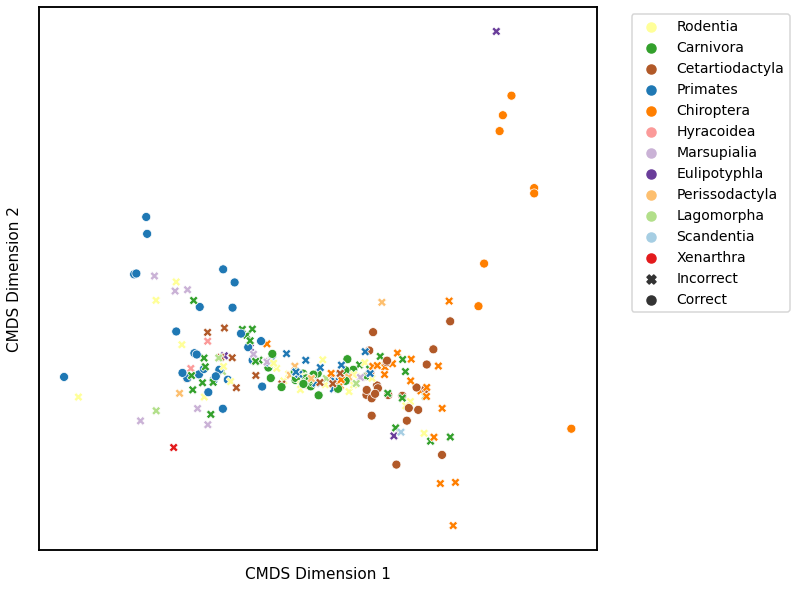

In [17]:
# cluster dissimilarity matrix
density_gm_embedding, density_gm_pred = cluster_dissim(scaled_density_dissim, y, method='gmm')
density_gm, density_gm_pred = construct_df(density_gm_embedding, labels, y, density_gm_pred)

# calculate accuracy and ARI
density_gm_score = accuracy_score(y, density_gm_pred)
density_gm_ari = adjusted_rand_score(y, density_gm_pred)

print(f"Accuracy: {density_gm_score}")
print(f"ARI: {density_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=density_gm)


### Average Edge Weight

Accuracy: 0.26666666666666666
ARI: 0.008804980985327957


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

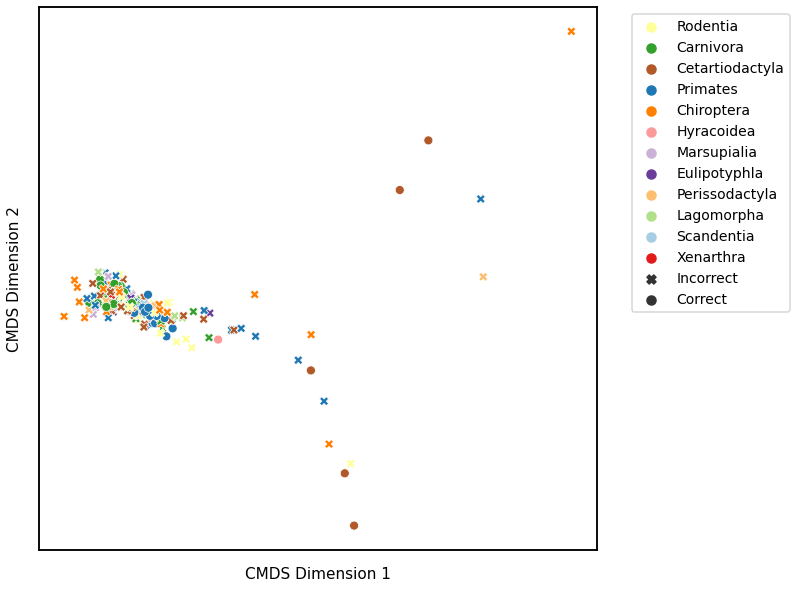

In [18]:
# cluster dissimilarity matrix
avgedgeweight_gm_embedding, avgedgeweight_gm_pred = cluster_dissim(scaled_avgedgeweight_dissim, y, method='gmm')
avgedgeweight_gm, avgedgeweight_gm_pred = construct_df(avgedgeweight_gm_embedding, labels, y, avgedgeweight_gm_pred)

# calculate accuracy and ARI
avgedgeweight_gm_score = accuracy_score(y, avgedgeweight_gm_pred)
avgedgeweight_gm_ari = adjusted_rand_score(y, avgedgeweight_gm_pred)

print(f"Accuracy: {avgedgeweight_gm_score}")
print(f"ARI: {avgedgeweight_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=avgedgeweight_gm)


### Average of the Adjacency Matrix

Accuracy: 0.28444444444444444
ARI: 0.02446558697903678


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

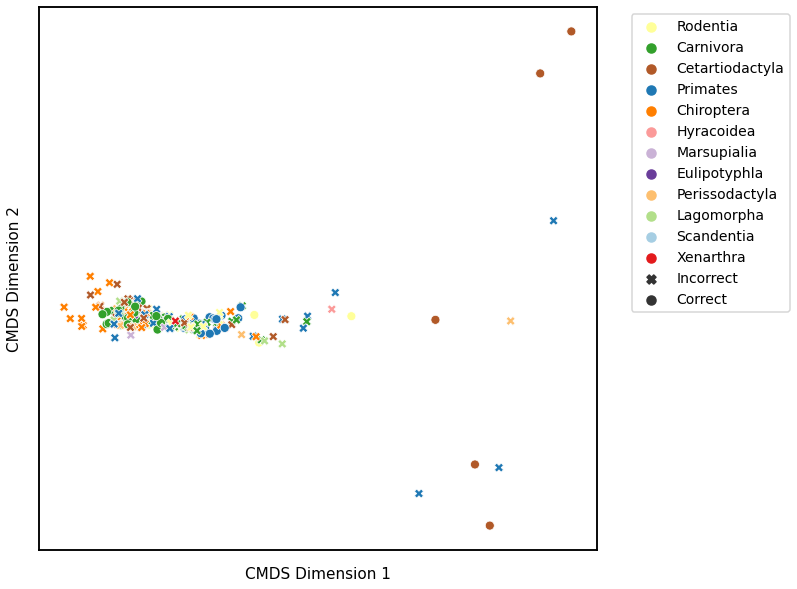

In [19]:
# cluster dissimilarity matrix
avgadjmat_gm_embedding, avgadjmat_gm_pred = cluster_dissim(scaled_avgadjmat_dissim, y, method="gmm")
avgadjmat_gm, avgadjmat_gm_pred = construct_df(avgadjmat_gm_embedding, labels, y, avgadjmat_gm_pred)

# calculate accuracy and ARI
avgadjmat_gm_score = accuracy_score(y, avgadjmat_gm_pred)
avgadjmat_gm_ari = adjusted_rand_score(y, avgadjmat_gm_pred)

print(f"Accuracy: {avgadjmat_gm_score}")
print(f"ARI: {avgadjmat_gm_ari}")


# plot clustering
plot_clustering(labels, 'gmm', data=avgadjmat_gm)


### Node Degrees

Accuracy: 0.38666666666666666
ARI: 0.09243542273855195


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

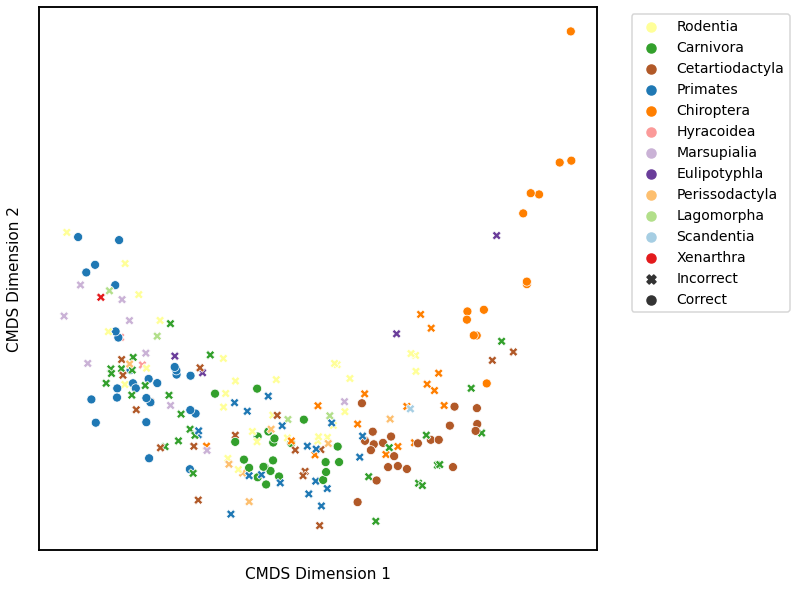

In [20]:
# cluster dissimilarity matrix
nodedeg_gm_embedding, nodedeg_gm_pred = cluster_dissim(scaled_nodedeg_dissim, y, method="gmm")
nodedeg_gm, nodedeg_gm_pred = construct_df(nodedeg_gm_embedding, labels, y, nodedeg_gm_pred)

# calculate accuracy and ARI
nodedeg_gm_score = accuracy_score(y, nodedeg_gm_pred)
nodedeg_gm_ari = adjusted_rand_score(y, nodedeg_gm_pred)

print(f"Accuracy: {nodedeg_gm_score}")
print(f"ARI: {nodedeg_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=nodedeg_gm)

### Node Strength

Accuracy: 0.31555555555555553
ARI: 0.04021177679760861


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

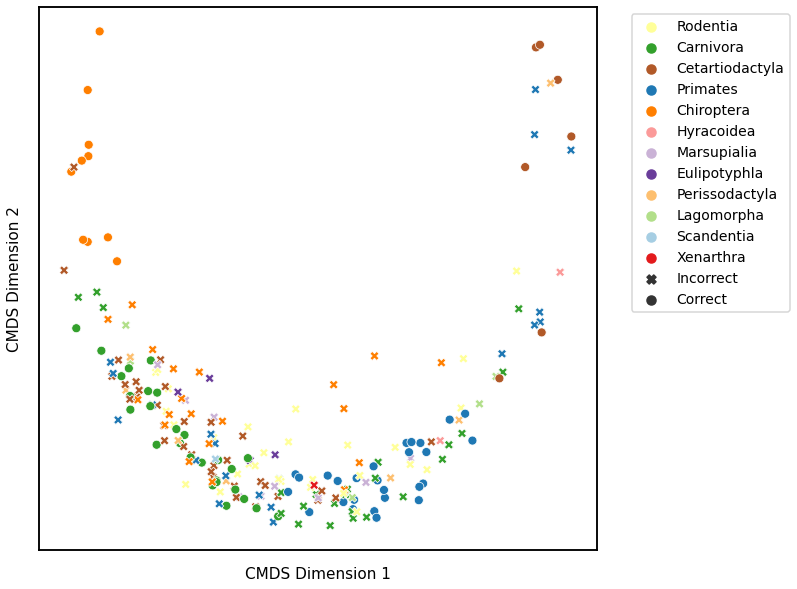

In [21]:
# cluster dissimilarity matrix
nodestr_gm_embedding, nodestr_gm_pred = cluster_dissim(scaled_nodestr_dissim, y, method="gmm")
nodestr_gm, nodestr_gm_pred = construct_df(nodestr_gm_embedding, labels, y, nodestr_gm_pred)

# calculate accuracy and ARI
nodestr_gm_score = accuracy_score(y, nodestr_gm_pred)
nodestr_gm_ari = adjusted_rand_score(y, nodestr_gm_pred)

print(f"Accuracy: {nodestr_gm_score}")
print(f"ARI: {nodestr_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=nodestr_gm)

### Edge Weights

Accuracy: 0.28444444444444444
ARI: 0.02790379338958105


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

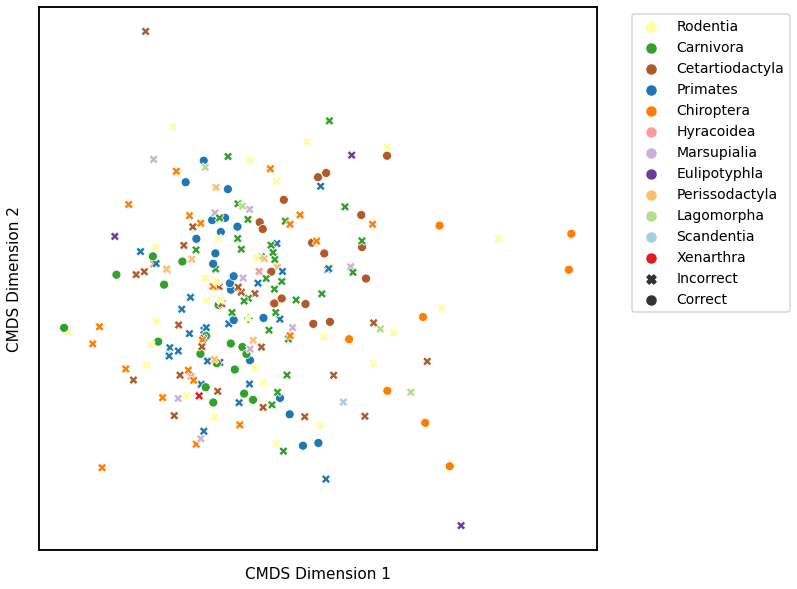

In [22]:
# cluster dissimilarity matrix
edgeweight_gm_embedding, edgeweight_gm_pred = cluster_dissim(scaled_edgeweight_dissim, y, method="gmm")
edgeweight_gm, edgeweight_gm_pred = construct_df(edgeweight_gm_embedding, labels, y, edgeweight_gm_pred)

# calculate accuracy and ARI
edgeweight_gm_score = accuracy_score(y, edgeweight_gm_pred)
edgeweight_gm_ari = adjusted_rand_score(y, edgeweight_gm_pred)

print(f"Accuracy: {edgeweight_gm_score}")
print(f"ARI: {edgeweight_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=edgeweight_gm)

### Omnibus Embedding (Change to Latent)

Accuracy: 0.25333333333333335
ARI: 0.012494712445882093


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

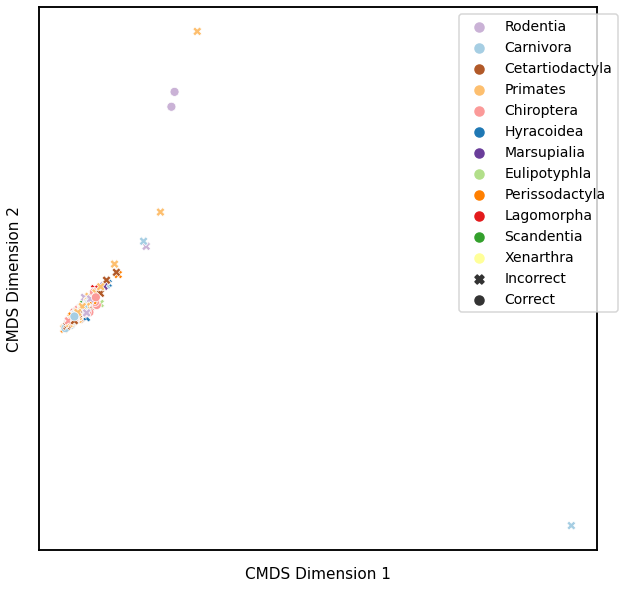

In [112]:
# cluster dissimilarity matrix
omni_gm_embedding, omni_gm_pred = cluster_dissim(scaled_omni_dissim, y, method="gmm")
omni_gm, omni_gm_pred = construct_df(omni_gm_embedding, labels, y, omni_gm_pred)

# calculate accuracy and ARI
omni_gm_score = accuracy_score(y, omni_gm_pred)
omni_gm_ari = adjusted_rand_score(y, omni_gm_pred)

print(f"Accuracy: {omni_gm_score}")
print(f"ARI: {omni_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=omni_gm)

## K-Means

Similar to GMM, we first used classical multidimensional scaling to embed the dissimilarity matrices into a 2-dimensional space, then used the K-Means clustering algorithm to predict the genotypes of each point. The clusters are shown in the scatterplot below, and the colors represent the predicted genotypes and the shapes (O or X) indicate whether or not those predictions were correct.

For each kernel, the raw accuracy score, the number of correct predictions divided by the total number of samples, and the adjusted rand index, a similarity measure between two clusterings after being adjusted for chance, were reported. 

### Density

Accuracy: 0.39111111111111113
ARI: 0.08888789188488591


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

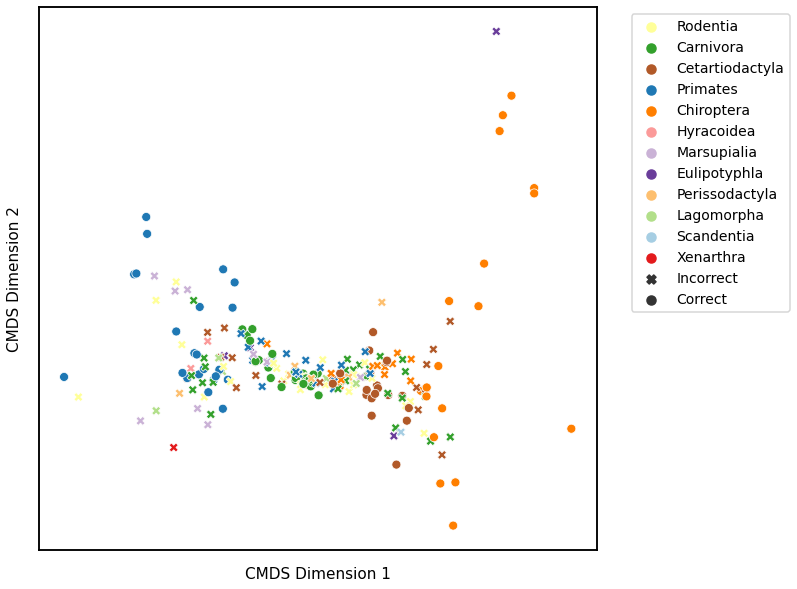

In [23]:
# cluster dissimilarity matrix
density_km_embedding, density_km_pred = cluster_dissim(scaled_density_dissim, y, method="kmeans")
density_km, density_km_pred = construct_df(density_km_embedding, labels, y, density_km_pred)

# calculate accuracy and ARI
density_km_score = accuracy_score(y, density_km_pred)
density_km_ari = adjusted_rand_score(y, density_km_pred)

print(f"Accuracy: {density_km_score}")
print(f"ARI: {density_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=density_km)

### Average Edge Weight

Accuracy: 0.27555555555555555
ARI: 0.01099989689491975


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

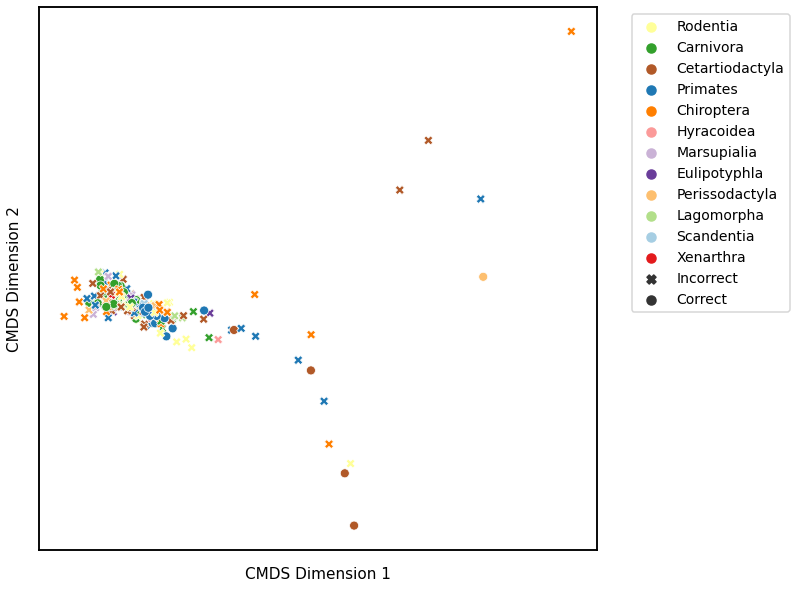

In [24]:
# cluster dissimilarity matrix
avgedgeweight_km_embedding, avgedgeweight_km_pred = cluster_dissim(scaled_avgedgeweight_dissim, y, method='kmeans')
avgedgeweight_km, avgedgeweight_km_pred = construct_df(avgedgeweight_km_embedding, labels, y, avgedgeweight_km_pred)

# calculate accuracy and ARI
avgedgeweight_km_score = accuracy_score(y, avgedgeweight_km_pred)
avgedgeweight_km_ari = adjusted_rand_score(y, avgedgeweight_km_pred)

print(f"Accuracy: {avgedgeweight_km_score}")
print(f"ARI: {avgedgeweight_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=avgedgeweight_km)

### Average of the Adjacency Matrix

Accuracy: 0.28
ARI: 0.038260960742600714


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

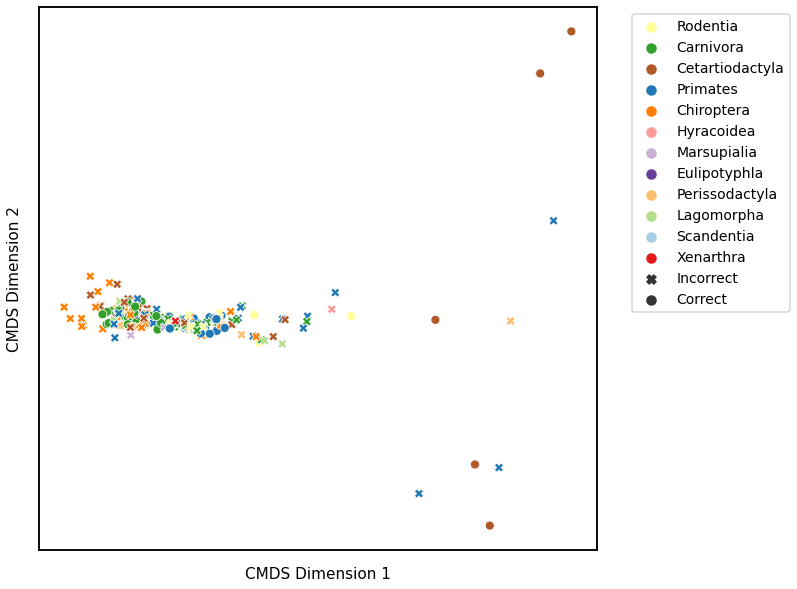

In [25]:
# cluster dissimilarity matrix
avgadjmat_km_embedding, avgadjmat_km_pred = cluster_dissim(scaled_avgadjmat_dissim, y, method='kmeans')
avgadjmat_km, avgadjmat_km_pred = construct_df(avgadjmat_km_embedding, labels, y, avgadjmat_km_pred)

# calculate accuracy and ARI
avgadjmat_km_score = accuracy_score(y, avgadjmat_km_pred)
avgadjmat_km_ari = adjusted_rand_score(y, avgadjmat_km_pred)

print(f"Accuracy: {avgadjmat_km_score}")
print(f"ARI: {avgadjmat_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=avgadjmat_km)

### Node Degree

Accuracy: 0.38666666666666666
ARI: 0.09041641145186005


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

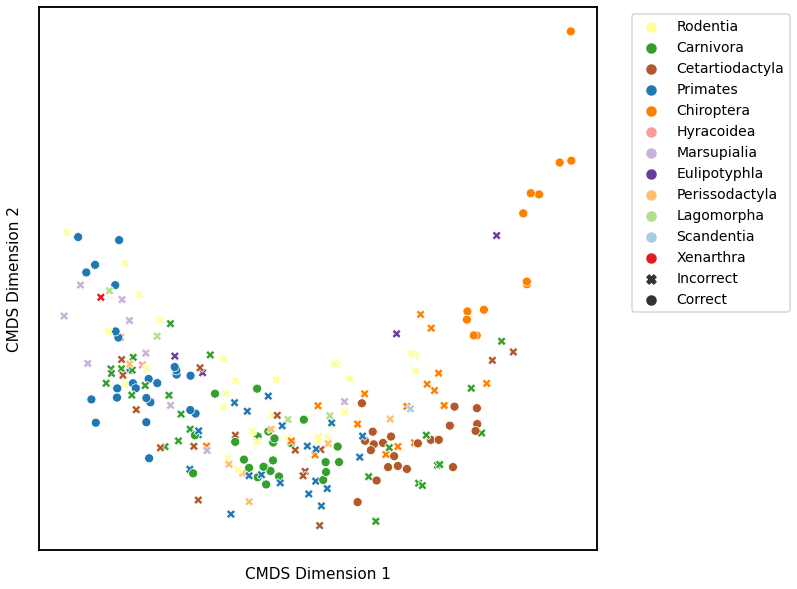

In [26]:
# cluster dissimilarity matrix
nodedeg_km_embedding, nodedeg_km_pred = cluster_dissim(scaled_nodedeg_dissim, y, method='kmeans')
nodedeg_km, nodedeg_km_pred = construct_df(nodedeg_km_embedding, labels, y, nodedeg_km_pred)

# calculate accuracy and ARI
nodedeg_km_score = accuracy_score(y, nodedeg_km_pred)
nodedeg_km_ari = adjusted_rand_score(y, nodedeg_km_pred)

print(f"Accuracy: {nodedeg_km_score}")
print(f"ARI: {nodedeg_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=nodedeg_km)

### Node Strength

Accuracy: 0.29777777777777775
ARI: 0.03134713996104464


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

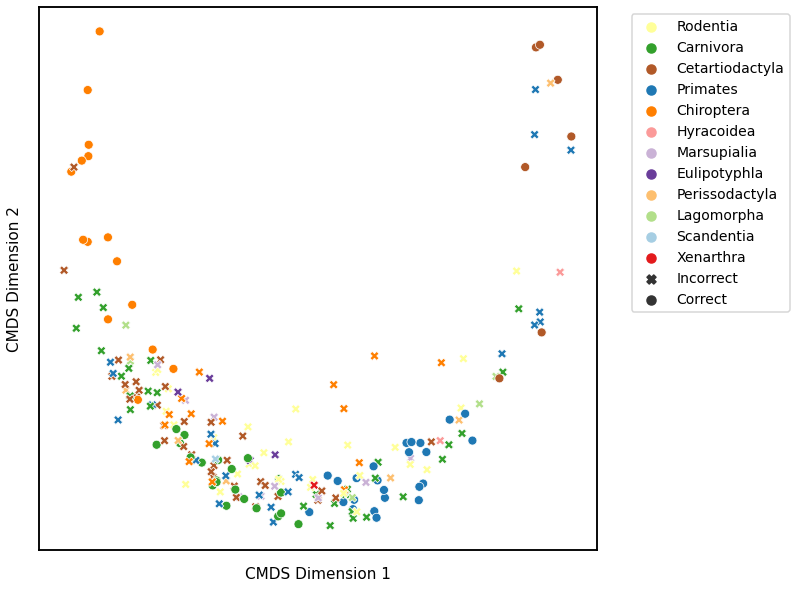

In [27]:
# cluster dissimilarity matrix
nodestr_km_embedding, nodestr_km_pred = cluster_dissim(scaled_nodestr_dissim, y, method='kmeans')
nodestr_km, nodestr_km_pred = construct_df(nodestr_km_embedding, labels, y, nodestr_km_pred)

# calculate accuracy and ARI
nodestr_km_score = accuracy_score(y, nodestr_km_pred)
nodestr_km_ari = adjusted_rand_score(y, nodestr_km_pred)

print(f"Accuracy: {nodestr_km_score}")
print(f"ARI: {nodestr_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=nodestr_km)

### Edge Weight

Accuracy: 0.31555555555555553
ARI: 0.04030996199985098


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

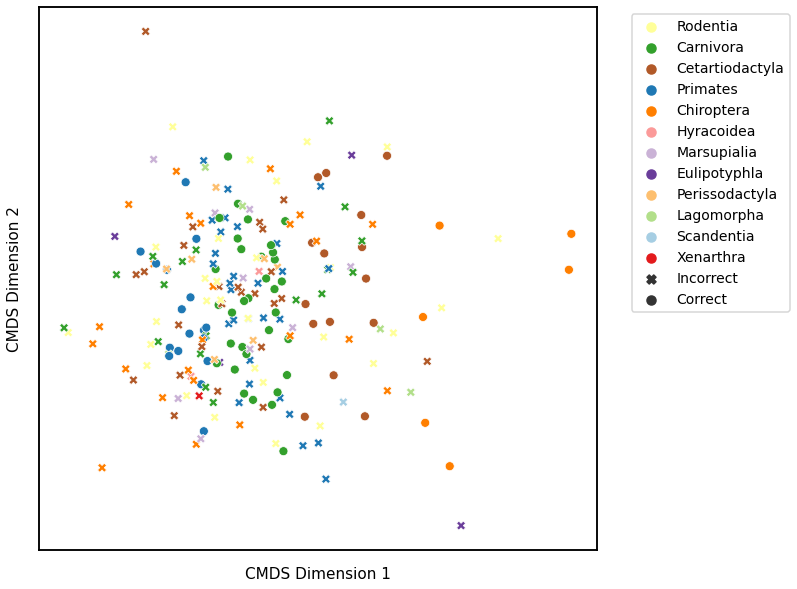

In [28]:
# cluster dissimilarity matrix
edgeweight_km_embedding, edgeweight_km_pred = cluster_dissim(scaled_edgeweight_dissim, y, method='kmeans')
edgeweight_km, edgeweight_km_pred = construct_df(edgeweight_km_embedding, labels, y, edgeweight_km_pred)

# calculate accuracy and ARI
edgeweight_km_score = accuracy_score(y, edgeweight_km_pred)
edgeweight_km_ari = adjusted_rand_score(y, edgeweight_km_pred)

print(f"Accuracy: {edgeweight_km_score}")
print(f"ARI: {edgeweight_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=edgeweight_km)

### Omnibus Embedding

Accuracy: 0.23555555555555555
ARI: 0.0005960765199224942


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

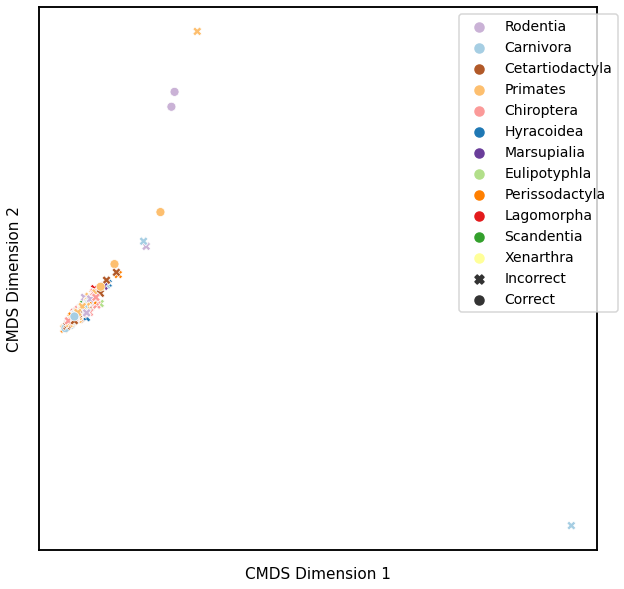

In [122]:
# cluster dissimilarity matrix
omni_km_embedding, omni_km_pred = cluster_dissim(scaled_omni_dissim, y, method='kmeans')
omni_km, omni_km_pred = construct_df(omni_km_embedding, labels, y, omni_km_pred)

# calculate accuracy and ARI
omni_km_score = accuracy_score(y, omni_km_pred)
omni_km_ari = adjusted_rand_score(y, omni_km_pred)

print(f"Accuracy: {omni_km_score}")
print(f"ARI: {omni_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=omni_km)

## ARI Plot

We will use the adjusted rand index (ARI) to compare the performace of each clustering algorithm on each kernel. The ARI values are visualized with a scatter plot below, and the colors represent the different clustering algorithms.

In [29]:
from graspologic.utils import symmetrize

# construct symmetric random matrix with zero diagonal
np.random.seed(42)
scaled_random = np.random.rand(len(graphs), len(graphs))
scaled_random = symmetrize(scaled_random)

# agglomerative clustering
random_linkage_matrix, random_pred = cluster_dissim(scaled_random, y, method="agg")
random_pred = remap_labels(y, random_pred)
random_agg_score = accuracy_score(y, random_pred)
random_agg_ari = adjusted_rand_score(y, random_pred)

# GMM
random_gm_embedding, random_gm_pred = cluster_dissim(scaled_random, y, method="gmm")
random_gm, random_gm_pred = construct_df(random_gm_embedding, labels, y, random_gm_pred)
random_gm_score = accuracy_score(y, random_gm_pred)
random_gm_ari = adjusted_rand_score(y, random_gm_pred)

# K-Means
random_km_embedding, random_km_pred = cluster_dissim(scaled_random, y, method="kmeans")
random_km, random_km_pred = construct_df(random_km_embedding, labels, y, random_km_pred)
random_km_score = accuracy_score(y, random_km_pred)
random_km_ari = adjusted_rand_score(y, random_km_pred)

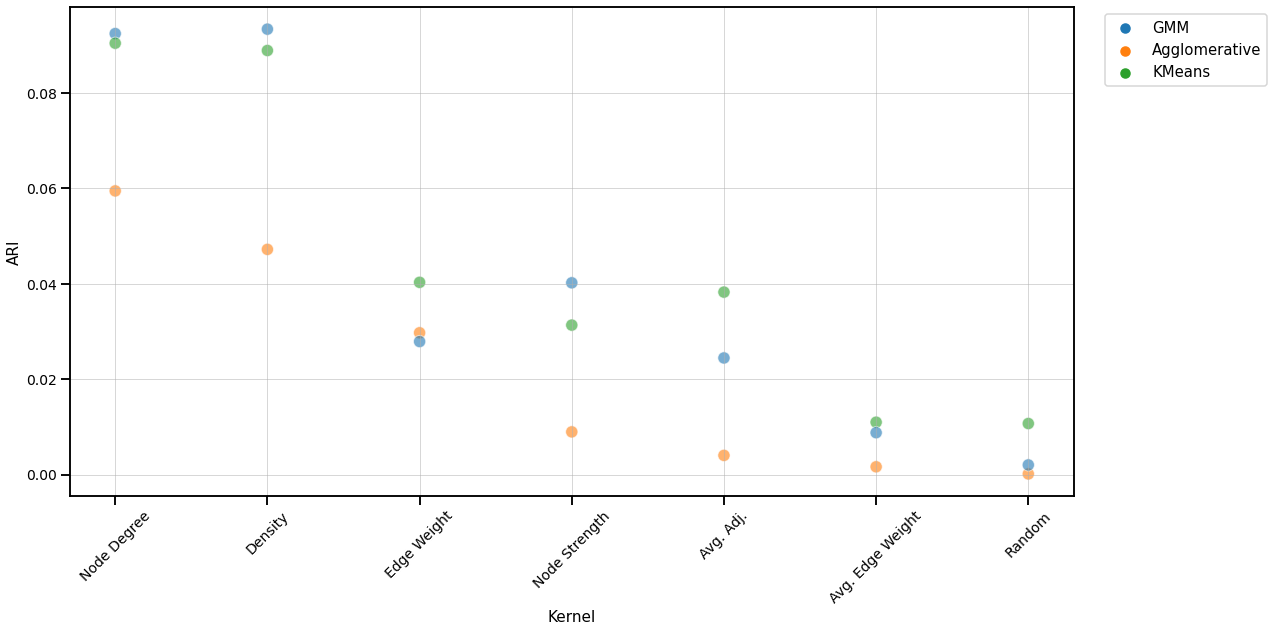

In [31]:
kernels = ['Density', 'Avg. Edge Weight', 'Avg. Adj.', 'Node Degree', 'Node Strength', \
    'Edge Weight', 'Random']
kernels_df = [kernel for kernel in kernels for i in range(3)]
agg_ari = [density_agg_ari, avgedgeweight_agg_ari, avgadjmat_agg_ari, nodedeg_agg_ari, \
    nodestr_agg_ari, edgeweight_agg_ari, random_agg_ari]
gm_ari = [density_gm_ari, avgedgeweight_gm_ari, avgadjmat_gm_ari, nodedeg_gm_ari, \
    nodestr_gm_ari, edgeweight_gm_ari, random_gm_ari]
km_ari = [density_km_ari, avgedgeweight_km_ari, avgadjmat_km_ari, nodedeg_km_ari, \
    nodestr_km_ari, edgeweight_km_ari, random_km_ari]

ari_vals = np.vstack((np.array(agg_ari), np.array(gm_ari), np.array(km_ari)))
ari_vals = np.ravel(ari_vals.T)
algos = ['Agglomerative', 'GMM', 'KMeans'] * len(agg_ari)

ari_df = pd.DataFrame(list(zip(kernels_df, ari_vals, algos)), columns=["Kernel", "ARI", "Algorithm"])

avg_ari_vals = (np.array(agg_ari) + np.array(gm_ari) + np.array(km_ari)) / 3
avg_ari_vals = [val for val in avg_ari_vals for i in range(3)]
ari_df["Average"] = avg_ari_vals
ari_df = ari_df.sort_values(by=['Average'], ascending=False)

fig, ax = plt.subplots(1,1, figsize=(18, 9), facecolor='w')
sns.set_context("talk", font_scale=0.9)
sns.scatterplot(x="Kernel", y="ARI", hue="Algorithm", data=ari_df, alpha=0.6, s=150)
plt.legend(bbox_to_anchor = (1.2, 1))
plt.xticks(rotation=45)
plt.grid(linewidth=0.5)